# Random Forest

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve, f1_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost.sklearn import XGBClassifier

In [9]:
adult = pd.read_csv('adult.csv')
adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


Adult dataset memiliki missing value yang ditandai dengan '?' pada kolom workclass, occupation, native.country

## Preprocessing

preprocessing scheme:
  - one hot encoding: relationship, race, sex
  - binary encoding: workclass, marital status, occupation, native country
  - ordinal encoding: education (already encoded)
  - no treatment: numerical
  - out: fnlwgt    

## Data Transformation

In [10]:
binary_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy = 'constant', fill_value = 'NC', missing_values ="?")),
    ('binary encoder', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'),['relationship','race','sex']),
    ('binary',binary_pipe,['workclass','marital.status','occupation','native.country'])
], remainder = 'passthrough')

## Data Splitting

In [11]:
x = adult.drop(['fnlwgt','education','income'],axis = 1)
y = np.where(adult['income']=='>50K',1,0)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify = y,
                                                    random_state = 10)

## Model Fitting and Evaluation: Decision Tree

In [13]:
tree = DecisionTreeClassifier(max_depth = 3)
pipe_tree = Pipeline([('transformer',transformer),
                     ('model',tree)])

In [14]:
pipe_tree.fit(x_train,y_train)

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                     

In [15]:
y_pred = pipe_tree.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.68      0.53      0.59      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141



## Model Properties: Feature Importance

In [16]:
pipe_tree[0].transformers_[0][1].get_feature_names()

array(['x0_Not-in-family', 'x0_Other-relative', 'x0_Own-child',
       'x0_Unmarried', 'x0_Wife', 'x1_Asian-Pac-Islander', 'x1_Black',
       'x1_Other', 'x1_White', 'x2_Male'], dtype=object)

In [17]:
pipe_tree[0].transformers_[1][1][1].get_feature_names()

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '3_5',
 '3_6']

In [18]:
features = list(pipe_tree[0].transformers_[0][1].get_feature_names()) + pipe_tree[0].transformers_[1][1][1].get_feature_names() + ['age','education.num','capital.gain','capital.loss','hours.per.week']

In [19]:
importance_tab = pd.DataFrame(pipe_tree[1].feature_importances_, columns = ['imp'],index = features)

importance_tab
#ambil model properties

,imp
x0_Not-in-family,0.000000
x0_Other-relative,0.000000
x0_Own-child,0.000000
x0_Unmarried,0.000000
x0_Wife,0.000000
x1_Asian-Pac-Islander,0.000000
x1_Black,0.000000
x1_Other,0.000000
x1_White,0.000000
x2_Male,0.000000


<AxesSubplot:>

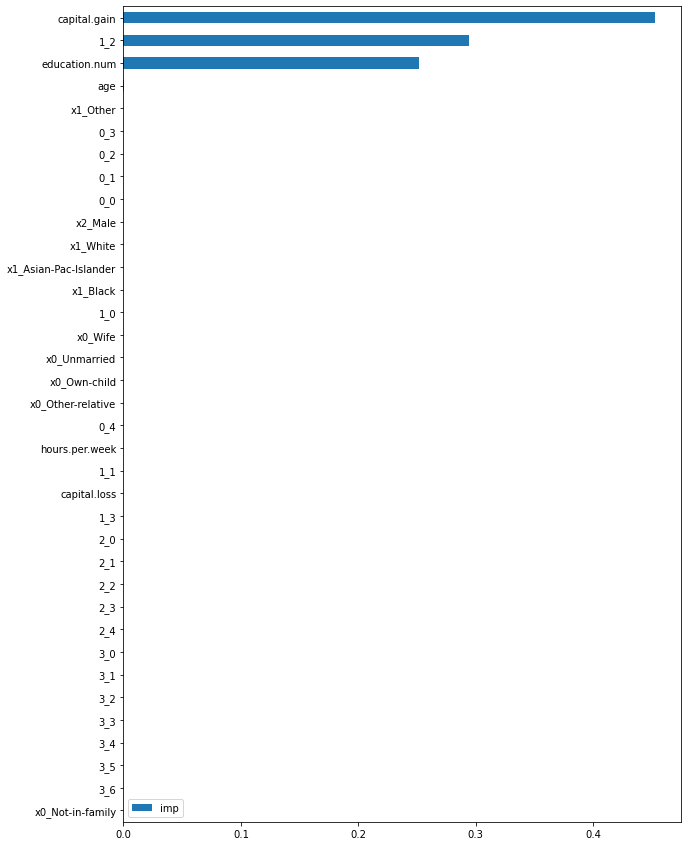

In [20]:
importance_tab.sort_values('imp').plot(kind = 'barh', figsize=(10,15))

[Text(558.0, 665.91, 'capital.gain <= 5119.0\ngini = 0.366\nsamples = 24420\nvalue = [18539, 5881]\nclass = <=50K'),
 Text(279.0, 475.65, '1_2 <= 0.5\ngini = 0.325\nsamples = 23225\nvalue = [18479, 4746]\nclass = <=50K'),
 Text(139.5, 285.39, 'education.num <= 12.5\ngini = 0.433\nsamples = 13867\nvalue = [9481, 4386]\nclass = <=50K'),
 Text(69.75, 95.13, 'gini = 0.348\nsamples = 10368\nvalue = [8040, 2328]\nclass = <=50K'),
 Text(209.25, 95.13, 'gini = 0.484\nsamples = 3499\nvalue = [1441, 2058]\nclass = >50K'),
 Text(418.5, 285.39, 'education.num <= 13.5\ngini = 0.074\nsamples = 9358\nvalue = [8998, 360]\nclass = <=50K'),
 Text(348.75, 95.13, 'gini = 0.053\nsamples = 8904\nvalue = [8661, 243]\nclass = <=50K'),
 Text(488.25, 95.13, 'gini = 0.383\nsamples = 454\nvalue = [337, 117]\nclass = <=50K'),
 Text(837.0, 475.65, 'capital.gain <= 7073.5\ngini = 0.095\nsamples = 1195\nvalue = [60, 1135]\nclass = >50K'),
 Text(697.5, 285.39, 'capital.gain <= 5316.5\ngini = 0.454\nsamples = 132\nvalu

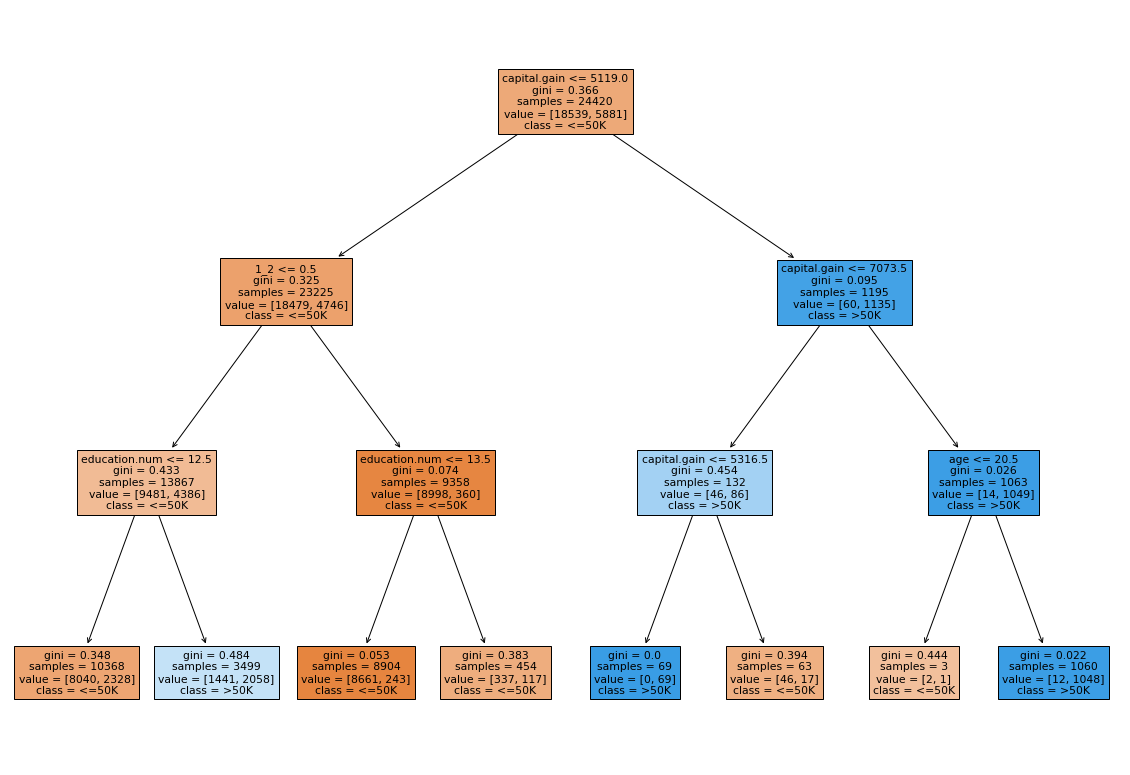

In [21]:
plt.figure(figsize = (20,14))
plot_tree(pipe_tree[1], feature_names = features, filled = True, class_names =['<=50K','>50K'])

## Model Fitting and Evaluation: Adaptive Boosting

AdaBoost: default DecisionTree, max_depth = 1

In [22]:
tree = DecisionTreeClassifier(max_depth = 3) #harus define decision tree dengan max depth yang dicustom
ada = AdaBoostClassifier(tree, n_estimators = 200, learning_rate = 0.1, random_state =10)

pipe_ada = Pipeline([
    ('transformer',transformer),
    ('model',ada)
])

In [23]:
pipe_ada.fit(x_train, y_train)
y_pred = pipe_ada.predict(x_test)
print(classification_report(y_test,y_pred))

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



## Model Properties: Feature Importance

In [24]:
importance_tab = pd.DataFrame({'imp':pipe_ada[1].feature_importances_},index= features)
importance_tab

,imp
x0_Not-in-family,0.009602
x0_Other-relative,0.009289
x0_Own-child,0.014575
x0_Unmarried,0.010174
x0_Wife,0.030319
x1_Asian-Pac-Islander,0.009420
x1_Black,0.011038
x1_Other,0.004983
x1_White,0.006060
x2_Male,0.025846


<AxesSubplot:>

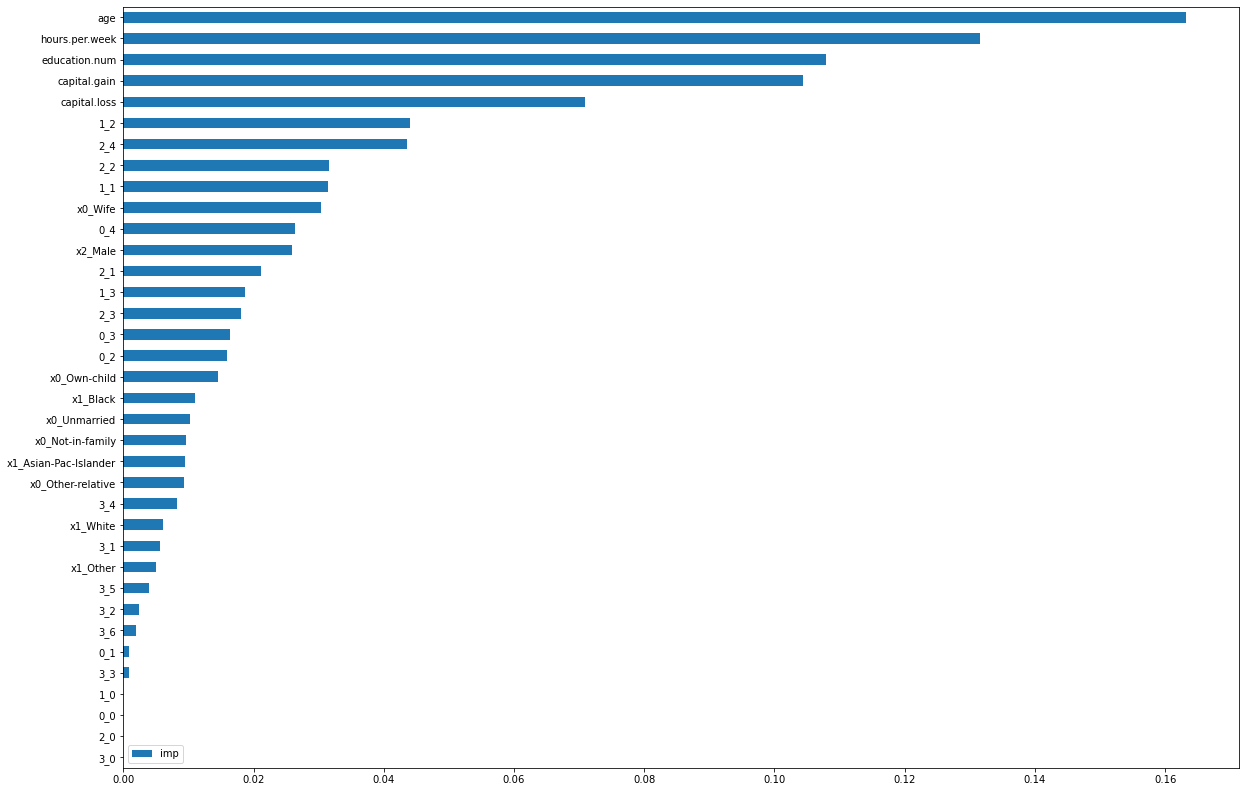

In [25]:
importance_tab.sort_values('imp').plot(kind='barh',figsize = (20,14))

## Model Fitting and Evaluation: Gradient Boosting

In [26]:
grad = GradientBoostingClassifier(max_depth = 3, #bisa langsung masukkin max_depth
                                   n_estimators = 200, 
                                   learning_rate = 0.1, random_state = 10)
pipe_grad = Pipeline([
    ('transformer',transformer),
    ('model',grad)
])

In [27]:
pipe_grad.fit(x_train, y_train)
y_pred = pipe_grad.predict(x_test)
print(classification_report(y_test,y_pred))

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



## Model Properties: Feature Importance

In [28]:
importance_tab = pd.DataFrame({'imp':pipe_grad[1].feature_importances_},index= features)
importance_tab

,imp
x0_Not-in-family,0.004850
x0_Other-relative,0.000241
x0_Own-child,0.001212
x0_Unmarried,0.001823
x0_Wife,0.008601
x1_Asian-Pac-Islander,0.000321
x1_Black,0.000388
x1_Other,0.000033
x1_White,0.000492
x2_Male,0.009060


<AxesSubplot:>

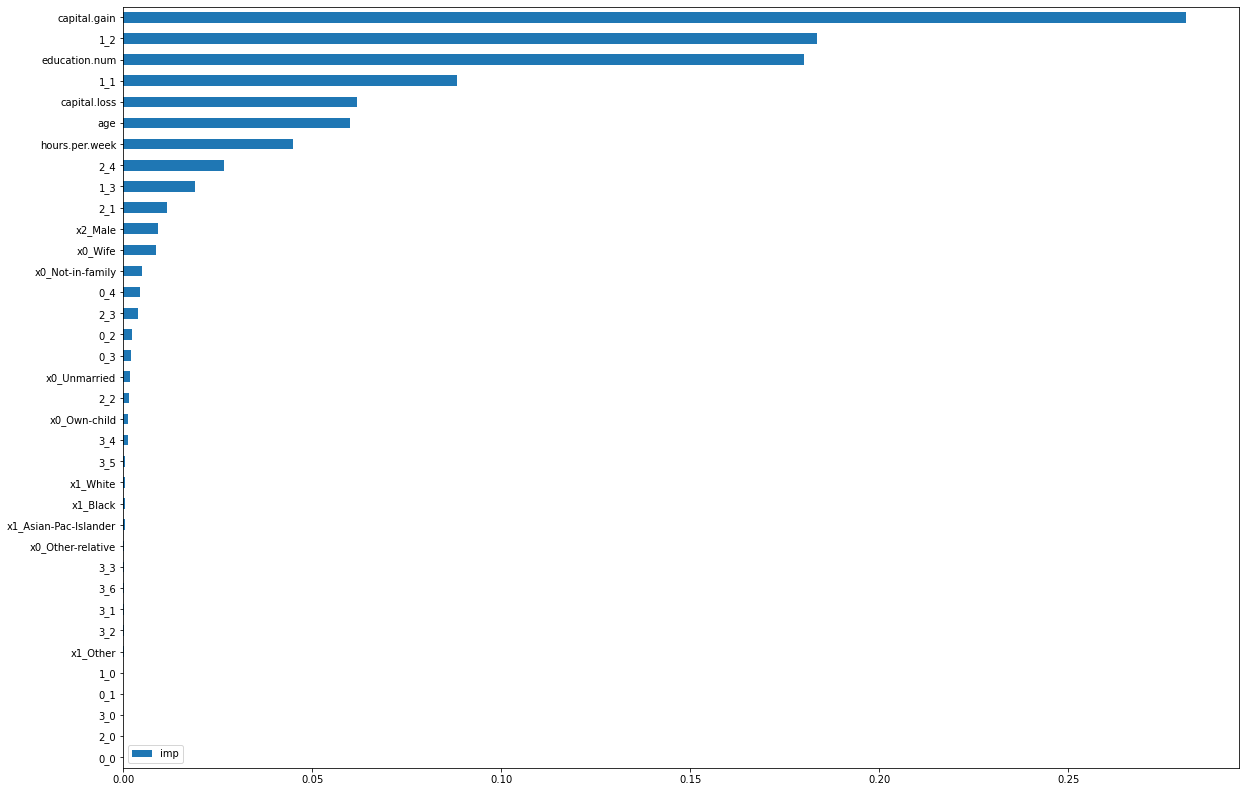

In [29]:
importance_tab.sort_values('imp').plot(kind='barh',figsize = (20,14))

## Model Fitting and Evaluation: Extreme Gradient Boosting

In [30]:
skfold = StratifiedKFold(n_splits = 5)

In [31]:
xgb = XGBClassifier(max_depth = 3,
                    n_estimators = 200, 
                    learning_rate = 0.1, 
                      random_state = 10)

pipe_xgb = Pipeline([
    ('transformer',transformer),
    ('model',xgb)
])

In [32]:
pipe_xgb.fit(x_train, y_train)
y_pred = pipe_xgb.predict(x_test)
print(classification_report(y_test,y_pred))

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:11:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



## Model Properties: Feature Importance

In [33]:
importance_tab = pd.DataFrame({'imp':pipe_xgb[1].feature_importances_},index= features)
importance_tab

,imp
x0_Not-in-family,0.019065
x0_Other-relative,0.005950
x0_Own-child,0.032394
x0_Unmarried,0.007194
x0_Wife,0.013635
x1_Asian-Pac-Islander,0.003121
x1_Black,0.003516
x1_Other,0.002723
x1_White,0.004893
x2_Male,0.023829


<AxesSubplot:>

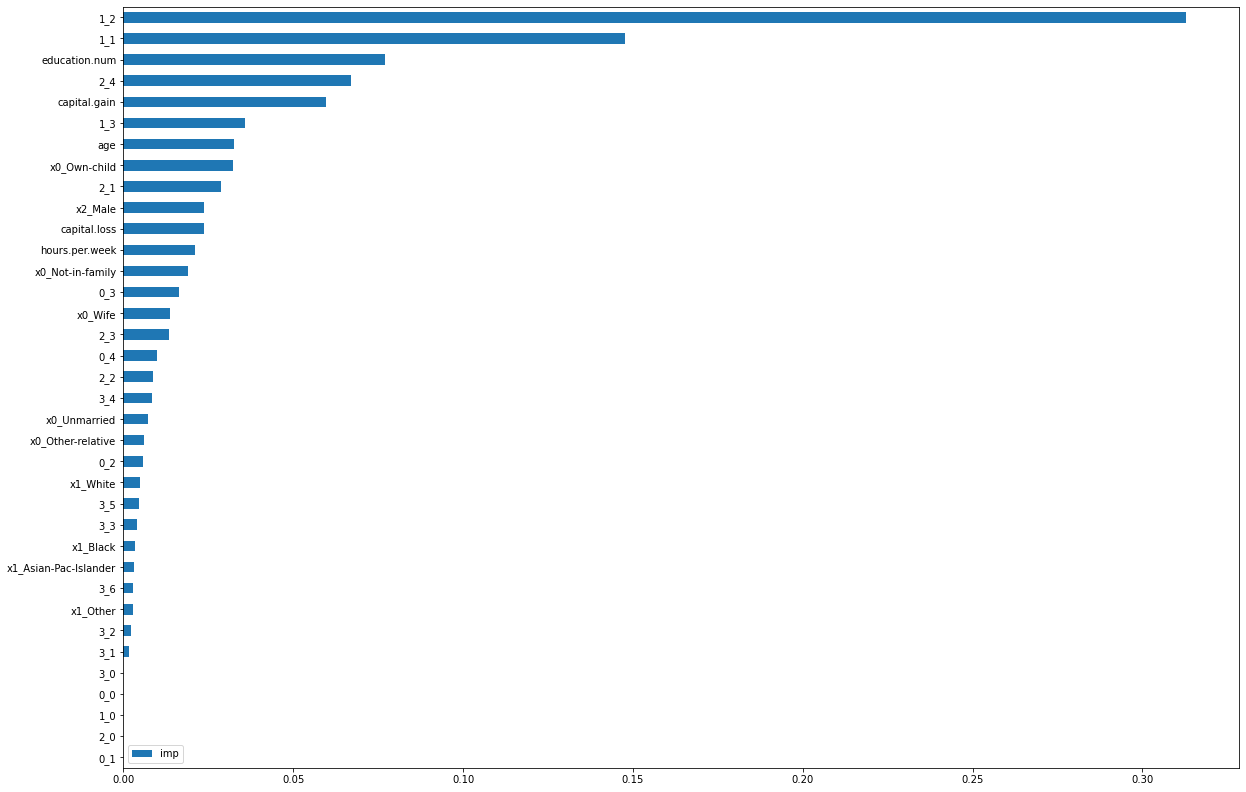

In [34]:
importance_tab.sort_values('imp').plot(kind='barh',figsize = (20,14))

#### Boosting ga bisa bikin pohon kaya Decision Tree --> Interpretasi tidak sebagus Decision Tree. Namun evaluasinya lebih bagus dibanding Decision Tree

Tugas: 

Pilihlah model terbaik dari 4 model di berikut sebagai benchmark model:
* Decision Tree
* Adaboost
* gradient boost
* XGboost  

Lakukan hyperparameter tunning dengan hyperparameter berikut:

hyperparam_space = [  
                    {'clf__learning_rate':[0.1],'clf__n_estimators':[200],'clf__base_estimator__max_depth':[3,4,5]},  
                    {'clf__learning_rate':[0.05],'clf__n_estimators':[400],'clf__base_estimator__max_depth':[3,4,5]},  
                    {'clf__learning_rate':[0.01],'clf__n_estimators':[2000],'clf__base_estimator__max_depth':[3,4,5]},  
                    {'clf__learning_rate':[0.005],'clf__n_estimators':[4000],'clf__base_estimator__max_depth':[3,4,5]}]  

Gunakan f1 score sebagai metric evaluasi

Kalian bisa upload tugas yg sudak kalian buat ke github kalian dan email link github kalian ke: Brigita.gems@gmail.com untuk feedback.

## Model Evaluation

In [35]:
import warnings
warnings.filterwarnings('ignore')


In [36]:
estimator= Pipeline([
    ('transformer', transformer),
    ('model',tree)
])

In [37]:
def model_evaluation (model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator=Pipeline([
        ('preprocess', transformer),
        ('model',model)
    ])
    model_cv = cross_val_score(estimator,x_train,y_train, cv = skfold, scoring = 'f1')
    return model_cv

In [38]:
def print_result(model_cv):
    print('CV score',model_cv)
    print('CV score mean', model_cv.mean())
    print('CV score std', model_cv.std())

In [39]:
model= tree

model_cv=model_evaluation(model)
print_result(model_cv)

CV score [0.61469265 0.59515899 0.59924027 0.60761905 0.61179829]
CV score mean 0.6057018496749238
CV score std 0.007410541558040793


In [40]:
model= ada

model_cv=model_evaluation(model)
print_result(model_cv)

CV score [0.7099768  0.70676692 0.68682097 0.69818529 0.72685398]
CV score mean 0.7057207928319411
CV score std 0.013265042110214115


In [41]:
model= grad

model_cv=model_evaluation(model)
print_result(model_cv)

CV score [0.69121813 0.69656489 0.68241966 0.70076482 0.72191011]
CV score mean 0.6985755212516678
CV score std 0.013179392117256446


In [42]:
model= xgb

model_cv=model_evaluation(model)
print_result(model_cv)

[11:13:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

**Berdasarkan hasil cross validation, Adaptive Boosting memiiki performa terbaik dan akan digunakan sebagai benchmark**

## Model Performance in Test Set

In [43]:
tree = DecisionTreeClassifier(max_depth = 3) #harus define decision tree dengan max depth yang dicustom
ada = AdaBoostClassifier(tree, n_estimators = 200, learning_rate = 0.1, random_state =10)

pipe_ada = Pipeline([
    ('transformer',transformer),
    ('model',ada)
])

In [44]:
pipe_ada.fit(x_train, y_train)
y_pred = pipe_ada.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [45]:
f1_score(y_test,y_pred)

0.6957507082152975

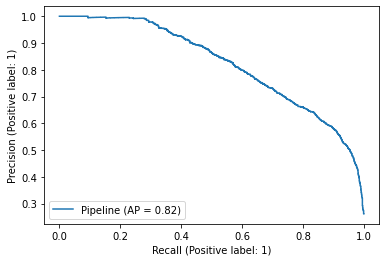

In [46]:
plot_precision_recall_curve(pipe_ada,x_test,y_test)

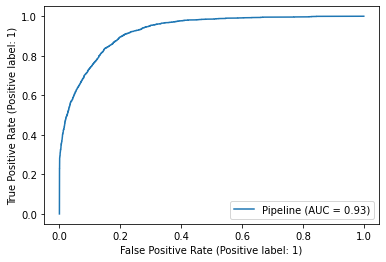

In [47]:
plot_roc_curve(pipe_ada, x_test,y_test)

## Hyperparameter Tuning

In [48]:
tree = DecisionTreeClassifier(max_depth = 3) #harus define decision tree dengan max depth yang dicustom
ada = AdaBoostClassifier(tree, n_estimators = 200, learning_rate = 0.1, random_state =10)

pipe_ada = Pipeline([
    ('transformer',transformer),
    ('model',ada)
])

In [49]:
hyperparam_space = [
{'model__learning_rate':[0.1],'model__n_estimators':[200],'model__base_estimator__max_depth':[3,4,5]},
{'model__learning_rate':[0.05],'model__n_estimators':[400],'model__base_estimator__max_depth':[3,4,5]},
{'model__learning_rate':[0.01],'model__n_estimators':[2000],'model__base_estimator__max_depth':[3,4,5]},
{'model__learning_rate':[0.005],'model__n_estimators':[4000],'model__base_estimator__max_depth':[3,4,5]}]
#udah dipasang-pasangin, supaya ga terlalu panjang runningnya

In [50]:
grid_search = GridSearchCV(
                pipe_ada,#model
                param_grid = hyperparam_space,#parameter yang ingin dituning
                cv = 5,
                scoring = 'f1',#metric
                n_jobs = -1)

In [51]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='NC',
                     

In [52]:
print('best_score',grid_search.best_score_)
print('best_param',grid_search.best_params_)

best_score 0.7073055622952331
best_param {'model__base_estimator__max_depth': 4, 'model__learning_rate': 0.1, 'model__n_estimators': 200}


## Final Results Comparison

In [53]:
tree = DecisionTreeClassifier(max_depth = 3) #harus define decision tree dengan max depth yang dicustom
ada = AdaBoostClassifier(tree, n_estimators = 200, learning_rate = 0.1, random_state =10)

pipe_ada = Pipeline([
    ('transformer',transformer),
    ('model',ada)
])

pipe_ada.fit(x_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                     

### Before Tuning

In [54]:
y_pred=pipe_ada.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [55]:
f1_score(y_test,y_pred)

0.6957507082152975

### After Tuning

In [56]:
grid_search.best_estimator_.fit(x_train,y_train)
y_pred=grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.77      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [57]:
f1_score(y_test,y_pred)

0.6967995508141493

No significant change from before to after hyperaparameter tuning. Hyperparameter tuning tidak meningkatkan performa model.